In [280]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import math
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss
from catboost import CatBoostClassifier, Pool

pd.set_option('display.max_columns', 500)

In [281]:
class Model:
    def __init__(self, cat_features_indices, params={'n_estimators': 500, 'learning_rate': 0.07}):
        self.cat_features_indices = cat_features_indices
        self.params = params
        
    def fit(self, X, y):
        pool = Pool(X, y, cat_features=self.cat_features_indices)
        self.model = CatBoostClassifier()
        self.model.set_params(**self.params)
        
        self.model.fit(pool)
        
    def predict(self, X):
        pool = Pool(X, cat_features=self.cat_features_indices)
        
        pred = self.model.predict_proba(pool)[:, 1]
        return pred
    
    def score(self, X, y):
        pred = self.predict(X)
        
        roc_auc_value = roc_auc_score(y, pred)
        log_loss_value = log_loss(y, pred)
        return roc_auc_value, log_loss_value
    
    def cross_validate(self, X, y):
        roc_auc_list = []
        log_loss_list = []
        kf = StratifiedKFold(5, shuffle=True, random_state=1)
        
        for train_idx, test_idx in kf.split(X, y):
            X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
            y_train, y_test = y[train_idx], y[test_idx]
            
            self.fit(X_train, y_train)
            ra, ll = self.score(X_test, y_test)
            
            roc_auc_list.append(ra)
            log_loss_list.append(ll)
        
        self.fit(X, y)
            
        print('ROC AUC: {}'.format(np.mean(roc_auc_list)))
        print('LOG LOSS: {}'.format(np.mean(log_loss_list)))
        print('roc auc folds: {}'.format(roc_auc_list))
        print('log loss folds: {}'.format(log_loss_list))
        return self.model

In [282]:
datetime.now().year

2020

In [285]:
def get_deadline(row):
    if row['wave_id'] == 1:
        return row['Level'] < 7
    if row['wave_id'] == 2:
        return row['Level'] < 5
    if row['wave_id'] == 3:
        return row['Level'] < 4
    return False

def prep_features(data):
    df = data.copy().rename({'Native city': 'city',
                             'Wave id': 'wave_id'}, axis=1)
    cities = pd.read_csv('data/cities_features.csv', names=['city', 'f1', 'f2','f3', 'f4','f5', 'f6', 'f7', 'f8'])
    cities = cities.sort_values(by='f1', ascending=False).drop_duplicates('city', keep='first')
    df = df.merge(cities, on='city', how='left')
    df.index = data.index
    df['age'] = ((datetime.now() - df['Birth date']).dt.days / 365).apply(math.floor)
    df['contract'] = df['Contract termination date'].isna().astype('int64')
    df['Life status'] = df['Life status'].astype(str)
    df['fail_deadline'] = df.apply(get_deadline, axis=1).astype(int)
#     df['lvl_wave_id'] = df['Level']..astype(str) + df['wave_id'].astype(str)
    return df

In [286]:
train = pd.read_csv('data/train.csv', index_col=0, parse_dates=[1])
features = ['age','Gender', 'Level', 'Life status', 'day_00', 'day_01', 'day_02',
       'day_03', 'day_04', 'day_05', 'day_06', 'day_07', 'day_08', 'day_09',
       'day_10', 'day_11', 'day_12', 'day_13', 'evalexpr', 'match_n_match',
       'bsq', 'rush_00', 'rush_01', 'rush_02', 'exam_00', 'exam_01', 'exam_02',
       'exam_final', 'contract', 'Memory entrance game', 'f1', 'f2','f3', 'f4','f5', 'f6', 'f7', 'f8',
        'Logic entrance game', 'wave_id', 'fail_deadline']
data = prep_features(train)[features]
y = train['contract_status'].values

In [287]:
X = data

map_feature_index = {j:i for i,j in enumerate(X.columns)}
cat_features = ['Gender', 'Life status', 'wave_id']
cat_features_indices = [map_feature_index[i] for i in cat_features]

model_params = {
    'random_state': 12,
    'n_estimators': 500,
    'learning_rate': 0.07,
    'verbose': 500
}

model = Model(cat_features_indices, model_params)
model.cross_validate(X, y)

0:	learn: 0.5927560	total: 11ms	remaining: 5.47s
499:	learn: 0.0060605	total: 1.94s	remaining: 0us
0:	learn: 0.5953283	total: 3.19ms	remaining: 1.59s
499:	learn: 0.0061376	total: 1.69s	remaining: 0us
0:	learn: 0.5922441	total: 3.69ms	remaining: 1.84s
499:	learn: 0.0051455	total: 1.73s	remaining: 0us
0:	learn: 0.5985491	total: 3.73ms	remaining: 1.86s
499:	learn: 0.0061189	total: 1.71s	remaining: 0us
0:	learn: 0.5938883	total: 5.44ms	remaining: 2.71s
499:	learn: 0.0063472	total: 1.82s	remaining: 0us
0:	learn: 0.6048011	total: 4.47ms	remaining: 2.23s
499:	learn: 0.0078654	total: 1.8s	remaining: 0us
ROC AUC: 0.9594435876324134
LOG LOSS: 0.1825050974026082
roc auc folds: [0.9658385093167702, 0.9658385093167702, 0.9446816770186335, 0.9592990390050875, 0.961560203504805]
log loss folds: [0.1778797089708592, 0.14328521321511895, 0.23996923535203682, 0.15128306865787924, 0.20010826081714678]


In [288]:
def make_prediction_file(model):
    test = pd.read_csv('data/test.csv', index_col=0, parse_dates=[1])
    
    test_df = prep_features(test)[features]
    pred = model.predict(test_df)
    pd.DataFrame(pred, index=test_df.index).reset_index().to_csv('prediction.csv', header=['id', 'contract_status', ''], index=False)
    return pred


In [ ]:
pred = make_prediction_file(model)

In [296]:
def get_feature_importance(model):
    feature_importance = model.model.get_feature_importance(Pool(X,label=y, cat_features=cat_features_indices))
    feature_score = pd.DataFrame(list(zip(X.dtypes.index, feature_importance)), 
                                 columns=['Feature','Score'])
    feature_score = feature_score.sort_values(by='Score',
                                              ascending=False,
                                              inplace=False,
                                              kind='quicksort',
                                              na_position='last')
    plt.rcParams["figure.figsize"] = (12,7)
    ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
    ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
    ax.set_xlabel('')

    rects = ax.patches

    labels = feature_score['Score'].round(2)

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

    plt.show()
    return feature_score

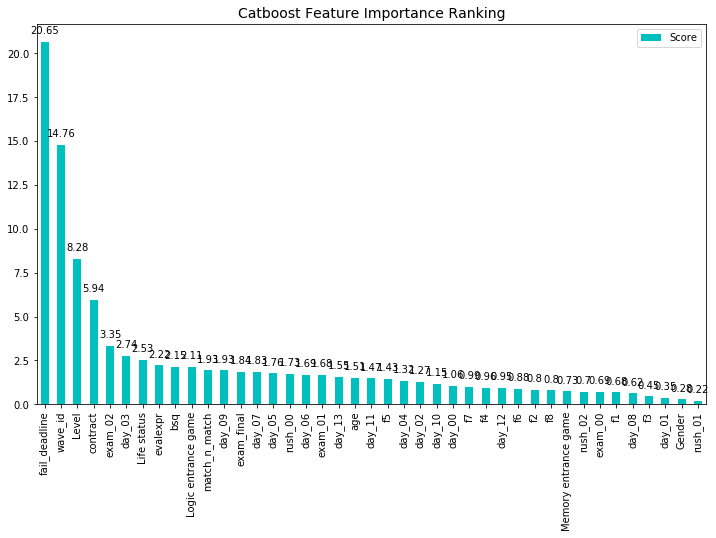

,Feature,Score
40,fail_deadline,20.645086
39,wave_id,14.762074
2,Level,8.284448
28,contract,5.943995
26,exam_02,3.347941
7,day_03,2.742650
3,Life status,2.531966
18,evalexpr,2.220400
20,bsq,2.151948
38,Logic entrance game,2.112252


In [297]:
get_feature_importance(model)